# Main Code file

In [36]:
import pandas as pd
import numpy as np

In [37]:
games = pd.read_csv("games.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
turns = pd.read_csv("turns.csv")

# Turns

### Words & Letters

In [39]:
import re
# Len of moves (remove dots)
turns['move_clean'] = turns['move'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z]', '', x))
turns['move_clean'] = turns['move_clean'].replace('.','')
turns['move_len'] = turns['move_clean'].apply(len)
# Len of rack
turns['rack_len'] = turns['rack'].str.len()

In [40]:
# difficult words
import textstat

turns["move"].fillna("None",inplace=True)
turns["difficult_word"] = turns["move"].apply(textstat.difficult_words)

In [41]:
# difficulty letters
difficult_letters = ["K", "J", "X", "Q", "Z"]
medium_letters = ["B", "C", "M", "P", "F", "H", "V", "W", "Y"]
easy_letters = ["A", "E", "I", "L", "N", "O", "R", "S", "T", "U", "D", "G"]

turns["difficult_letters"] = turns["move_clean"].apply(lambda x: len([letter for letter in x if letter in difficult_letters]))
turns["medium_letters"] = turns["move_clean"].apply(lambda x: len([letter for letter in x if letter in medium_letters]))
turns["easy_letters"] = turns["move_clean"].apply(lambda x: len([letter for letter in x if letter in easy_letters]))

# blank tiles = 0 points
turns["blank_used"] = turns["move_clean"].apply(lambda x: sum(1 for letter in x if letter.islower()))

# bingo = extra 50 points
turns["is_bingo"] = turns["move_len"].apply(lambda x: 1 if x==7 else 0)

### location bonus

In [42]:
def location_bonus(location):
    bonus = 0
    if location in triple_word_score_lo:
        bonus = 4
    elif location in double_word_socre_lo:
        bonus = 3
    elif location in triple_letter_score_lo:
        bonus = 2
    elif location in double_letter_score_lo:
        bonus = 1
    return bonus
    
triple_word_score_lo = ['1A','3H','1O']
double_word_socre_lo = ['2B','3C','4D','5E','8H','5K','4L','3M','2O','14B','13C','12D','11E','11K','12L','13M','14N']
triple_letter_score_lo = ['2F','2J','6B','6F','6J','6N','10B','10F','10J','10N','14F','14J']
double_letter_score_lo = ['1D','1L','3G','3I','4A','4H','4O','7C','7G','7I','7M',\
                          '8D','8L','9C','9G','9I','9M','12A','12H','12O','13G','13I',\
                          '15D','15L']


In [43]:
turns['bonus'] = turns["location"].apply(location_bonus)

### Turn Type

In [44]:
# Group by 'game_id' and 'nickname', and then 'turn_type', and count the occurrences
turn_type_counts = turns.groupby(['game_id', 'nickname', 'turn_type']).size().reset_index(name='count')
# Pivot the table to get turn types as columns and their counts as values
pivot_table = turn_type_counts.pivot_table(index=['game_id', 'nickname'], columns='turn_type', values='count', fill_value=0)
# Reset the index to turn the MultiIndex into columns
pivot_table.reset_index(inplace=True)
# Flatten the columns after pivot
pivot_table.columns = [''.join(col).strip() if col[1] else col[0] for col in pivot_table.columns.values]
pivot_table.head()

,game_id,nickname,Challenge,End,Exchange,Pass,Play,Six-Zero Rule,Timeout
0,1,BetterBot,0,0,0,0,13,0,0
1,1,stevy,0,1,0,0,13,0,0
2,2,BetterBot,0,0,0,0,12,0,0
3,2,Super,0,1,1,1,11,0,0
4,3,BetterBot,0,0,1,0,12,0,0


### turns_agg

In [45]:
# agg turns data
turns_agg = turns.groupby(["game_id", "nickname"]).agg(
    total_score=('score', 'last'),
    avg_point=('points', 'mean'),
    max_point=('points', 'max'),
    avg_move_len=('move_len', 'mean'),
    max_move_len=('move_len', 'max'),
    difficult_words=('difficult_word', 'sum'),
    difficult_letters=('difficult_letters', 'sum'),
    medium_letters=('medium_letters', 'sum'),
    easy_letters=('easy_letters', 'sum'),
    blank_used=('blank_used', 'sum'),
    bingo_cnt=('is_bingo', 'sum'),
    total_bonus=('bonus', 'sum'),
    avg_bonus=('bonus', 'mean')
)
turns_agg.head()

total_score  avg_point  max_point  avg_move_len  \
game_id nickname                                                     
1       BetterBot          335  25.769231         68      4.000000   
        stevy              429  30.642857         98      3.428571   
2       BetterBot          401  33.416667         85      4.250000   
        Super              488  34.857143         94      3.857143   
3       BetterBot          318  24.461538         76      3.692308   

                   max_move_len  difficult_words  difficult_letters  \
game_id nickname                                                      
1       BetterBot             7                3                  3   
        stevy                 7                1                  2   
2       BetterBot             7                3                  3   
        Super                 7                5                  2   
3       BetterBot             7                2                  3   

                   medium_letters  easy_letters  blank_used  bingo_cnt  \
game_id nickname                                                         
1       BetterBot               9            40           0          1   
        stevy                   9            35           2          2   
2       BetterBot               6            41           1          3   
        Super                  13            38           1          3   
3       BetterBot              11            33           1          1   

                   total_bonus  avg_bonus  
game_id nickname                           
1       BetterBot            3   0.230769  
        stevy                8   0.571429  
2       BetterBot            6   0.500000  
        Super                2   0.142857  
3       BetterBot            7   0.538462

# Merge

In [46]:
df = train.merge(turns_agg, how="left", on=["game_id", "nickname"])
df = df.merge(pivot_table, how="left", on=["game_id", "nickname"])

test_df = test.merge(turns_agg, how="left", on=["game_id", "nickname"])
test_df = test_df.merge(pivot_table, how="left", on=["game_id", "nickname"])

df.head()

,game_id,nickname,score,rating,total_score,avg_point,max_point,avg_move_len,max_move_len,difficult_words,difficult_letters,medium_letters,easy_letters,blank_used,bingo_cnt,total_bonus,avg_bonus
0,1,BetterBot,335,1637,335,25.769231,68,4.000000,7,3,3,9,40,0,1,3,0.230769
1,1,stevy,429,1500,429,30.642857,98,3.428571,7,1,2,9,35,2,2,8,0.571429
2,3,davidavid,440,1811,440,31.428571,103,3.857143,7,2,4,7,42,1,1,3,0.214286
3,3,BetterBot,318,2071,318,24.461538,76,3.692308,7,2,3,11,33,1,1,7,0.538462
4,4,Inandoutworker,119,1473,119,8.500000,26,1.857143,6,1,0,9,17,0,0,11,0.785714


In [47]:
# Create bot df
bot_names =["BetterBot", "STEEBot", "HastyBot"]
bot_df = df[["game_id", "nickname", "score", "rating"]].copy()
bot_df['bot_name'] = bot_df['nickname'].apply(lambda x: x if x in bot_names else np.nan)
bot_df = bot_df[["game_id", "score", "rating", "bot_name"]].dropna(subset=["bot_name"])
bot_df.columns = ["game_id", "bot_score", "bot_rating", "bot_name"]
bot_df.head()

test_bot_df = test_df[["game_id", "nickname", "score", "rating"]].copy()
test_bot_df['bot_name'] = test_bot_df['nickname'].apply(lambda x: x if x in bot_names else np.nan)
test_bot_df = test_bot_df[["game_id", "score", "rating", "bot_name"]].dropna(subset=["bot_name"])
test_bot_df.columns = ["game_id", "bot_score", "bot_rating", "bot_name"]
test_bot_df.head()

,game_id,bot_score,bot_rating,bot_name
1,2,401,2000.0,BetterBot
2,7,377,2082.0,STEEBot
4,11,334,1829.0,STEEBot
6,14,403,2136.0,STEEBot
9,27,453,2258.0,HastyBot


In [48]:
# Bot scores don't change much, I think we should focus on how the player 
# rakings were calculated.
# Put their info in players feature to show the level and rank dif instead

# Skip next 2 lines if you still want to calculate bots.
df = df[~df['nickname'].isin(bot_names)] #take out the bots
df = df.merge(bot_df, on="game_id") #add in bot information

# merge game information
df = df.merge(games, on="game_id") 
df["created_at"] = pd.to_datetime(df["created_at"])
df.head()



test_df = test_df[~test_df['nickname'].isin(bot_names)] #take out the bots
test_df = test_df.merge(test_bot_df, on="game_id") #add in bot information

# merge game information
test_df = test_df.merge(games, on="game_id") 
test_df["created_at"] = pd.to_datetime(test_df["created_at"])
test_df.head()

,game_id,nickname,score,rating,total_score,avg_point,max_point,avg_move_len,max_move_len,difficult_words,...,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,2,Super,488,NaN,488,34.857143,94,3.857143,7,5,...,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
1,7,Priya1,379,NaN,379,29.153846,68,3.384615,7,1,...,regular,STANDARD,1,2022-08-26 03:07:48,CSW21,1260,0,RATED,1,385.599607
2,11,TileRunner,462,NaN,462,33.000000,66,3.928571,7,3,...,regular,STANDARD,1,2022-08-22 01:13:10,NWL20,1200,0,CASUAL,1,501.739156
3,14,Anfield223,359,NaN,359,23.933333,98,3.266667,7,1,...,regular,STANDARD,0,2022-09-14 14:06:24,CSW21,900,0,RATED,1,293.253051
4,27,friesbasil,456,NaN,456,41.454545,90,4.000000,7,1,...,regular,STANDARD,1,2022-09-13 09:12:15,CSW21,1200,0,RATED,1,203.963230


In [49]:
df.shape

(50410, 31)

In [50]:
test_df.shape

(22363, 31)

### game level

In [51]:
# define game level
conditions = [
    (df['nickname'] == "BetterBot") | (df['first'] == "BetterBot"),
    (df['nickname'] == "STEEBot") | (df['first'] == "STEEBot"),
    (df['nickname'] == "HastyBot") | (df['first'] == "HastyBot")
]
conditions2 = [
    (test_df['nickname'] == "BetterBot") | (test_df['first'] == "BetterBot"),
    (test_df['nickname'] == "STEEBot") | (test_df['first'] == "STEEBot"),
    (test_df['nickname'] == "HastyBot") | (test_df['first'] == "HastyBot")
]

choices = [1, 2, 3]

df['game_level'] = np.select(conditions, choices, default=0)
test_df['game_level'] = np.select(conditions2, choices, default=0)
df.head(5)

,game_id,nickname,score,rating,total_score,avg_point,max_point,avg_move_len,max_move_len,difficult_words,...,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,game_level
0,1,stevy,429,1500,429,30.642857,98,3.428571,7,1,...,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,1
1,3,davidavid,440,1811,440,31.428571,103,3.857143,7,2,...,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,1
2,4,Inandoutworker,119,1473,119,8.500000,26,1.857143,6,1,...,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,1
3,5,stevy,325,1500,325,20.312500,51,2.875000,5,1,...,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722,2
4,6,HivinD,378,2029,378,31.500000,74,4.083333,6,2,...,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541,0


### First player

In [52]:
# first player or not
conditions = [
    (df['nickname'] == df['first']),
    (df['nickname'] != df['first']),
]

conditions2 = [
    (test_df['nickname'] == test_df['first']),
    (test_df['nickname'] != test_df['first']),
]

choices = [1, 0]

df['is_first_player'] = np.select(conditions, choices, default=0)
test_df['is_first_player'] = np.select(conditions2, choices, default=0)
df.head(5)

,game_id,nickname,score,rating,total_score,avg_point,max_point,avg_move_len,max_move_len,difficult_words,...,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,game_level,is_first_player
0,1,stevy,429,1500,429,30.642857,98,3.428571,7,1,...,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,1,0
1,3,davidavid,440,1811,440,31.428571,103,3.857143,7,2,...,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,1,0
2,4,Inandoutworker,119,1473,119,8.500000,26,1.857143,6,1,...,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,1,0
3,5,stevy,325,1500,325,20.312500,51,2.875000,5,1,...,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722,2,0
4,6,HivinD,378,2029,378,31.500000,74,4.083333,6,2,...,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541,0,1


In [53]:
# get the only 1500 rating players and drop them
users_1500 = df[df["rating"] == 1500]["nickname"]
anomalous = df[df["nickname"].isin(users_1500)].groupby("nickname").\
    agg({'nickname':'count', 'rating' : lambda x : np.sum(x == 1500)})

anomalous["ratio"] = anomalous["rating"] / anomalous["nickname"]
anomalous_users = anomalous[(anomalous["ratio"] >= 1.0) & (anomalous["nickname"] > 1)].index
df = df[~df["nickname"].isin(anomalous_users)]


In [54]:
df.columns

Index(['game_id', 'nickname', 'score', 'rating', 'total_score', 'avg_point',
       'max_point', 'avg_move_len', 'max_move_len', 'difficult_words',
       'difficult_letters', 'medium_letters', 'easy_letters', 'blank_used',
       'bingo_cnt', 'total_bonus', 'avg_bonus', 'bot_score', 'bot_rating',
       'bot_name', 'first', 'time_control_name', 'game_end_reason', 'winner',
       'created_at', 'lexicon', 'initial_time_seconds', 'increment_seconds',
       'rating_mode', 'max_overtime_minutes', 'game_duration_seconds',
       'game_level', 'is_first_player'],
      dtype='object')

In [55]:
test_df.columns

Index(['game_id', 'nickname', 'score', 'rating', 'total_score', 'avg_point',
       'max_point', 'avg_move_len', 'max_move_len', 'difficult_words',
       'difficult_letters', 'medium_letters', 'easy_letters', 'blank_used',
       'bingo_cnt', 'total_bonus', 'avg_bonus', 'bot_score', 'bot_rating',
       'bot_name', 'first', 'time_control_name', 'game_end_reason', 'winner',
       'created_at', 'lexicon', 'initial_time_seconds', 'increment_seconds',
       'rating_mode', 'max_overtime_minutes', 'game_duration_seconds',
       'game_level', 'is_first_player'],
      dtype='object')

### One Hot Encodeing

In [56]:
import category_encoders as ce
# , "lexicon", "rating_mode"
encoder = ce.OneHotEncoder(cols=["bot_name", "game_end_reason"], use_cat_names=True)
df = df.join(encoder.fit_transform(df[["bot_name", "game_end_reason"]]))
test_df = test_df.join(encoder.fit_transform(test_df[["bot_name", "game_end_reason"]]))

In [57]:
df.head()

,game_id,nickname,score,rating,total_score,avg_point,max_point,avg_move_len,max_move_len,difficult_words,...,game_duration_seconds,game_level,is_first_player,bot_name_BetterBot,bot_name_STEEBot,bot_name_HastyBot,game_end_reason_STANDARD,game_end_reason_RESIGNED,game_end_reason_TIME,game_end_reason_CONSECUTIVE_ZEROES
1,3,davidavid,440,1811,440,31.428571,103,3.857143,7,2,...,492.268262,1,0,1,0,0,1,0,0,0
2,4,Inandoutworker,119,1473,119,8.500000,26,1.857143,6,1,...,350.861141,1,0,1,0,0,0,1,0,0
4,6,HivinD,378,2029,378,31.500000,74,4.083333,6,2,...,426.950541,0,1,0,1,0,1,0,0,0
5,8,AliSalman1,414,2067,414,37.636364,91,4.272727,7,3,...,458.019893,3,0,0,0,1,1,0,0,0
6,9,cccc,364,1641,364,24.266667,88,3.466667,7,2,...,567.144135,1,0,1,0,0,1,0,0,0


In [58]:
def win_or_not(row):
    win = 0
    if row['nickname'] == row['first'] and row['winner'] == 1:
        win = 1
        return win
    elif row['nickname'] != row['first'] and row['winner'] == 0:
        win = 1
        return win
    else:
        return win

df['win_or_not'] = df.apply(win_or_not, axis = 1)
test_df['win_or_not'] = test_df.apply(win_or_not, axis = 1)

In [59]:
df.columns

Index(['game_id', 'nickname', 'score', 'rating', 'total_score', 'avg_point',
       'max_point', 'avg_move_len', 'max_move_len', 'difficult_words',
       'difficult_letters', 'medium_letters', 'easy_letters', 'blank_used',
       'bingo_cnt', 'total_bonus', 'avg_bonus', 'bot_score', 'bot_rating',
       'bot_name', 'first', 'time_control_name', 'game_end_reason', 'winner',
       'created_at', 'lexicon', 'initial_time_seconds', 'increment_seconds',
       'rating_mode', 'max_overtime_minutes', 'game_duration_seconds',
       'game_level', 'is_first_player', 'bot_name_BetterBot',
       'bot_name_STEEBot', 'bot_name_HastyBot', 'game_end_reason_STANDARD',
       'game_end_reason_RESIGNED', 'game_end_reason_TIME',
       'game_end_reason_CONSECUTIVE_ZEROES', 'win_or_not'],
      dtype='object')

### Cummulative

In [60]:
def cumm_player_features(df, window_width):
    # game_features = ["nickname", "created_at","score","winner", "game_duration_seconds"]
    # cat_features = ["bot_name", "rating_mode", "lexicon", "game_end_reason"]
    # df = df[cat_features]
    
    original_df_columns = df.columns
    df= df.sort_values(by=["nickname", "created_at"])

    df['rolling_score_avg'] = (df.groupby('nickname')['score'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df['score']) / (df.groupby('nickname')['score'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
    df['rolling_win'] = (df.groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df['win_or_not']) 
    df['rolling_win_rate'] = df['rolling_win'] / (df.groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
    df['rolling_game_time'] = (df.groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df['game_duration_seconds']) / (df.groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)

    # df[df.columns.difference(original_df_columns)] = df[df.columns.difference(original_df_columns)].fillna(0)

    df = df.sort_index()
    return df[df.columns.difference(original_df_columns)]

In [61]:
def cumm_turn_features(df, window_width):
    game_features = ["nickname", "created_at","score","winner", "game_duration_seconds"]
    # cat_features = ["bot_name", "rating_mode", "lexicon", "game_end_reason"]
    # df = df[cat_features]
   
    df= df.sort_values(by=["nickname", "created_at"])
    
    turn_features = ['total_score', 'avg_point',
       'max_point', 'avg_move_len', 'max_move_len', 'difficult_words',
       'difficult_letters', 'medium_letters', 'easy_letters', 'blank_used',
       'bingo_cnt', 'total_bonus', 'avg_bonus']
    #, 'Challenge', 'End', 'Exchange','Pass', 'Play', 'Six-Zero Rule', 'Timeout'
    original_df_columns = df.columns
    
    for feature in turn_features:
         df[f'rolling_{feature}'] = (df.groupby('nickname')[feature].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df[feature]) / (df.groupby('nickname')[feature].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)

    # df[df.columns.difference(original_df_columns)] = df[df.columns.difference(original_df_columns)].fillna(0)
    
    df = df.sort_index()
    return df[df.columns.difference(original_df_columns)]
   

In [62]:
def cumm_player_features_bot(df, window_width):
    df= df.sort_values(by=["nickname", "created_at"])
    original_df_columns = df.columns

    for bot_name in df["bot_name"].unique():
        df[f'rolling_score_avg_{bot_name}'] = (df[df['bot_name'] == bot_name].groupby(['nickname'])['score'].rolling(window=window_width, min_periods=1) \
               .sum().reset_index(level=0, drop=True) - df[df['bot_name'] == bot_name]['score']) / (df[df['bot_name'] == bot_name].groupby('nickname') \
                ['score'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
        
        df[f'rolling_win_{bot_name}'] = (df[df['bot_name'] == bot_name].groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1) \
                .sum().reset_index(level=0, drop=True) - df[df['bot_name'] == bot_name]['win_or_not']) 
        
        df[f'rolling_win_rate_{bot_name}'] = df[df['bot_name'] == bot_name][f'rolling_win_{bot_name}'] / (df[df['bot_name'] == bot_name] \
                .groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
        df[f'rolling_game_time_{bot_name}'] = (df[df['bot_name'] == bot_name].groupby('nickname')['game_duration_seconds']. \
                rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df['game_duration_seconds']) \
                / (df[df['bot_name'] == bot_name].groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1) \
                   .count().reset_index(level=0, drop=True) - 1)
    
   #  df[df.columns.difference(original_df_columns)] = df[df.columns.difference(original_df_columns)].fillna(0)

    df = df.sort_index()
    return df[df.columns.difference(original_df_columns)]

In [63]:
all_lexicon = ['CSW21', 'NWL20', 'ECWL', 'NSWL20']
all_rating_mode = ['RATED', 'CASUAL']

In [64]:
def cumm_player_features_lexicon(df, window_width):
    df= df.sort_values(by=["nickname", "created_at"])
    original_df_columns = df.columns

    for lexicon in df["lexicon"].unique():
        df[f'rolling_score_avg_{lexicon}'] = (df[df['lexicon'] == lexicon].groupby(['nickname'])['score'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df[df['lexicon'] == lexicon]['score']) / (df[df['lexicon'] == lexicon].groupby('nickname')['score'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
        df[f'rolling_win_{lexicon}'] = (df[df['lexicon'] == lexicon].groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df[df['lexicon'] == lexicon]['win_or_not']) 
        df[f'rolling_win_rate_{lexicon}'] = df[df['lexicon'] == lexicon][f'rolling_win_{lexicon}'] / (df[df['lexicon'] == lexicon].groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
        df[f'rolling_game_time_{lexicon}'] = (df[df['lexicon'] == lexicon].groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df['game_duration_seconds']) / (df[df['lexicon'] == lexicon].groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
    # df[df.columns.difference(original_df_columns)] = df[df.columns.difference(original_df_columns)].fillna(0)
    
    df = df.sort_index()
    return df[df.columns.difference(original_df_columns)]

In [65]:
def cumm_player_features_lexicon_rating_mode(df, window_width):
    df= df.sort_values(by=["nickname", "created_at"])
    original_df_columns = df.columns

    for lexicon in all_lexicon:
        for mode in all_rating_mode:
            df[f'rolling_score_avg_{lexicon}_{mode}'] = (df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)].groupby(['nickname'])['score'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)]['score']) / (df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)].groupby('nickname')['score'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
            df[f'rolling_win_{lexicon}_{mode}'] = (df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)].groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)]['win_or_not']) 
            df[f'rolling_win_rate_{lexicon}_{mode}'] = df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)][f'rolling_win_{lexicon}_{mode}'] / (df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)].groupby('nickname')['win_or_not'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
            df[f'rolling_game_time_{lexicon}_{mode}'] = (df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)].groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1).sum().reset_index(level=0, drop=True) - df['game_duration_seconds']) / (df[(df['lexicon'] == lexicon) & (df['rating_mode'] == mode)].groupby('nickname')['game_duration_seconds'].rolling(window=window_width, min_periods=1).count().reset_index(level=0, drop=True) - 1)
    # df[df.columns.difference(original_df_columns)] = df[df.columns.difference(original_df_columns)].fillna(0)
    
    df = df.sort_index()
    return df[df.columns.difference(original_df_columns)]

## Unfinished
Still Need more cummulative features

# Testing Performance

Set a scorer to test if it improves performances by adding features

In [66]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold
def xgb_score(X, y):
    # delete "device='cuda'" if you are using CPU
    model=XGBRegressor(device='cuda', n_estimators=1000, random_state=42)
    scores = cross_validate(
        model, X, y, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True
    )
    return {"Training":-1 * np.mean(scores["train_score"]), "Validation":-1 * np.mean(scores["test_score"])}

def lgbm_score(X, y):
    model=LGBMRegressor(n_estimators=1000, verbose=-1, random_state=42)
    scores = cross_validate(
        model, X, y, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True
    )
    
    return {"Training":-1 * np.mean(scores["train_score"]), "Validation":-1 * np.mean(scores["test_score"])}

In [67]:
window_width = 30

cat_features = encoder.get_feature_names()
drop_columns = ["game_id", "nickname", "first", "time_control_name", "winner", "created_at", 'increment_seconds', 
            "bot_name", "rating_mode", "lexicon", "game_end_reason", "game_level"]
X = df.join(cumm_player_features(df.copy(), window_width))
X = X.join(cumm_turn_features(df.copy(), window_width))
X = X.join(cumm_player_features_bot(df.copy(), window_width))
X = X.join(cumm_player_features_lexicon_rating_mode(df.copy(), window_width))
X = X.drop(drop_columns, axis=1)
X = X.drop(['rating'], axis=1)
# X = X.drop(['lexicon_NSWL20'], axis=1)
y = df["rating"]

test_X = test_df.join(cumm_player_features(test_df.copy(), window_width))
test_X = test_X.join(cumm_turn_features(test_df.copy(), window_width))
test_X = test_X.join(cumm_player_features_bot(test_df.copy(), window_width))
test_X = test_X.join(cumm_player_features_lexicon_rating_mode(test_df.copy(), window_width))
test_X = test_X.drop(drop_columns, axis=1)
test_X = test_X.drop(['rating'], axis=1)


/home/eric/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


KeyError: 'Column not found: Challenge'

In [ ]:
# ##Without original
# cat_features = encoder.get_feature_names()
# drop_columns = ["game_id", "nickname", "first", "time_control_name", "winner", "created_at", 'increment_seconds', 
#             "bot_name", "rating_mode", "lexicon", "game_end_reason", "game_level"]

# X = cumm_player_features(df.copy(), cat_features)
# X = cumm_turn_features(df.copy(), cat_features)
# X = X.join(cumm_player_features_bot(df.copy()))
# X = X.join(cumm_player_features_lexicon(df.copy()))
# # X = X.drop(drop_columns, axis=1)
# # X = X.drop(['rating'], axis=1)
# # X = X.drop(['lexicon_NSWL20'], axis=1)
# y = df["rating"]

# test_X = cumm_player_features(test_df.copy(), cat_features)
# test_X = test_X.join(cumm_turn_features(test_df.copy(), cat_features))
# test_X = test_X.join(cumm_player_features_bot(test_df.copy()))
# test_X = test_X.join(cumm_player_features_lexicon(test_df.copy()))
# # test_X = test_X.drop(drop_columns, axis=1)
# # test_X = test_X.drop(['rating'], axis=1)


In [405]:
xgb_score(X,y)

{'Training': 4.3991866487000335, 'Validation': 58.09928104897862}

In [430]:
xgb_score(X,y)

{'Training': 4.218743604491624, 'Validation': 57.545816649126}

In [ ]:
lgbm_score(X, y)

In [284]:
X.columns

Index(['score', 'total_score', 'avg_point', 'max_point', 'avg_move_len',
       'max_move_len', 'difficult_words', 'difficult_letters',
       'medium_letters', 'easy_letters', 'blank_used', 'bingo_cnt',
       'total_bonus', 'avg_bonus', 'Challenge', 'End', 'Exchange', 'Pass',
       'Play', 'Six-Zero Rule', 'Timeout', 'bot_score', 'bot_rating',
       'initial_time_seconds', 'max_overtime_minutes', 'game_duration_seconds',
       'is_first_player', 'bot_name_BetterBot', 'bot_name_STEEBot',
       'bot_name_HastyBot', 'rating_mode_RATED', 'rating_mode_CASUAL',
       'game_end_reason_STANDARD', 'game_end_reason_RESIGNED',
       'game_end_reason_TIME', 'game_end_reason_CONSECUTIVE_ZEROES',
       'win_or_not', 'rolling_score_avg', 'rolling_win', 'rolling_win_rate',
       'rolling_game_time', 'rolling_Challenge', 'rolling_End',
       'rolling_Exchange', 'rolling_Pass', 'rolling_Play',
       'rolling_Six-Zero Rule', 'rolling_Timeout', 'rolling_avg_bonus',
       'rolling_avg_move_len

In [285]:
test_X.columns

Index(['score', 'total_score', 'avg_point', 'max_point', 'avg_move_len',
       'max_move_len', 'difficult_words', 'difficult_letters',
       'medium_letters', 'easy_letters', 'blank_used', 'bingo_cnt',
       'total_bonus', 'avg_bonus', 'Challenge', 'End', 'Exchange', 'Pass',
       'Play', 'Six-Zero Rule', 'Timeout', 'bot_score', 'bot_rating',
       'initial_time_seconds', 'max_overtime_minutes', 'game_duration_seconds',
       'is_first_player', 'bot_name_BetterBot', 'bot_name_STEEBot',
       'bot_name_HastyBot', 'rating_mode_RATED', 'rating_mode_CASUAL',
       'game_end_reason_STANDARD', 'game_end_reason_TIME',
       'game_end_reason_RESIGNED', 'game_end_reason_CONSECUTIVE_ZEROES',
       'win_or_not', 'rolling_score_avg', 'rolling_win', 'rolling_win_rate',
       'rolling_game_time', 'rolling_Challenge', 'rolling_End',
       'rolling_Exchange', 'rolling_Pass', 'rolling_Play',
       'rolling_Six-Zero Rule', 'rolling_Timeout', 'rolling_avg_bonus',
       'rolling_avg_move_len

In [346]:
X.shape

(42959, 103)

In [347]:
test_X.shape

(22363, 103)

In [91]:
float64_columns = X.select_dtypes(include='float64').columns
X[float64_columns] = X[float64_columns].astype('float32')

In [ ]:
# OrderedDict([('colsample_bytree', 0.9976711301647266),
#              ('learning_rate', 0.13510239564313328),
#              ('max_depth', 11),
#              ('n_estimators', 4888),
#              ('reg_alpha', 60.59189135519744),
#              ('reg_lambda', 82.42684788701875),
#              ('subsample', 0.919963067589978)])

In [68]:
# xgb_model = XGBRegressor(device='cuda', colsample_bytree =0.7, learning_rate = 0.0968, max_depth = 4, n_estimators = 150, reg_alpha = 1, reg_lambda = 1, subsample = 0.9)
xgb_model = XGBRegressor(device='cuda', colsample_bytree =0.7, learning_rate = 0.13510239564313328, max_depth = 11, n_estimators = 150, reg_alpha = 1, reg_lambda = 1, subsample = 0.9)
xgb_model.fit(X, y) # 0.08968078915104692
names = xgb_model.get_booster().feature_names
test_X = test_X[names]
predictions_xgb = xgb_model.predict(test_X)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:nickname: object, bot_name: object, first: object, time_control_name: object, game_end_reason: object, created_at: datetime64[ns], lexicon: object, rating_mode: object

In [446]:
bayes_xgb = XGBRegressor(device='cuda', colsample_bytree =0.9976711301647266, 
                   learning_rate = 0.13510239564313328, max_depth = 11, n_estimators = 4888, 
                   reg_alpha = 60.59189135519744, reg_lambda = 82.42684788701875,
                   subsample = 0.919963067589978)
bayes_xgb.fit(X,y)

# prediction_op = clf.predict(test_X)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9976711301647266, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.13510239564313328, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=4888, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [452]:
# {'lambda_l1': 2.0928847153901296e-05, 'lambda_l2': 3.0615004064163866e-05, 
#  'num_leaves': 85, 'feature_fraction': 0.5585923616941331, 'bagging_fraction': 0.9445686687356669, 
#  'bagging_freq': 14, 'min_child_samples': 76}
lgb_model = LGBMRegressor(lambda_l1=2.0928847153901296e-05,
                          lambda_l2=3.0615004064163866e-05, 
                          num_leaves=85, 
                          feature_fraction=0.5585923616941331,
                          bagging_fraction=0.9445686687356669,
                          bagging_freq=14, min_child_samples=76)


In [453]:
from sklearn.ensemble import VotingRegressor
ensemble_model = VotingRegressor([('xgb_model_1', xgb_model), ('xgb_model_2', bayes_xgb),
                                 ('lgb_model', lgb_model)])
ensemble_model.fit(X, y)
predictions_ensemble = ensemble_model.predict(test_X)

[LightGBM] [Warning] feature_fraction is set=0.5585923616941331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585923616941331
[LightGBM] [Warning] lambda_l2 is set=3.0615004064163866e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0615004064163866e-05
[LightGBM] [Warning] lambda_l1 is set=2.0928847153901296e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0928847153901296e-05
[LightGBM] [Warning] bagging_fraction is set=0.9445686687356669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9445686687356669
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5585923616941331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585923616941331
[LightGBM] [Warning] lambda_l2 is set=3.0615004064163866e-05, reg_lambda

In [35]:
test = pd.read_csv("test.csv")
test = test[~test['nickname'].str.endswith('Bot')]
# test['rating'] = predictions_xgb
# test['rating'] = predictions_ensemble
test['rating'] = predictions_xgb
submission = test[['game_id','rating']]
submission.to_csv("xgboost_submission_final.csv",index=False)

In [166]:
rf_model = RandomForestRegressor()
rf_model.fit(X, y) # 0.08968078915104692
# names = rf_model.get_booster().feature_names
# test_X = test_X[names]
predictions_rf = rf_model.predict(test_X)
    #'max_features': ['auto', 'sqrt'],
    # 'min_samples_leaf': [1,2,5], #2,5
    # 'max_depth': [3, 5, 7, 9],
    #'min_samples_split': [2, 3, 4],
    # 'max_samples': [0.7,0.9,1]

/home/eric/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [ ]:
test = pd.read_csv("test.csv")
test = test[~test['nickname'].str.endswith('Bot')]
test['rating'] = predictions_rf.values

submission = test[['game_id','rating']]
# submission.to_csv("xgboost_submission_2.csv",index=False)
submission.to_csv("rf_2.csv",index=False)

In [414]:
import cudf
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import cuml
import cupy as cp
import numpy as np
from cuml.svm import SVR
from cuml.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from cuml.ensemble import RandomForestRegressor
#from catboost import CatBoostRegressor

from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from cuml.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

NUM_TRIALS = 1

# RandomForestRegressor: Non-Nested CV Avg RMSE: 95.887, Std Dev: 0.000
# RandomForestRegressor: Nested CV Avg RMSE: 95.884, Std Dev: 0.000
# Best parameters found: [{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}]
p_grid_rf = {
    'n_estimators': [100,300,500,1000], #10,50
    #'max_features': ['auto', 'sqrt'],
    # 'min_samples_leaf': [1,2,5], #2,5
    # 'max_depth': [3, 5, 7, 9],
    #'min_samples_split': [2, 3, 4],
    # 'max_samples': [0.7,0.9,1]
}

# Best parameters found: [{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 0.9}]  rmse95
p_grid_xgb = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9], #0.5,1
    'colsample_bytree': [0.7, 0.8, 0.9]
}
search_space_xgb = {
    # 'learning_rate': Real(0.01, 1.0, 'uniform'),
    #  'max_depth': Integer(2, 12),
    #  'subsample': Real(0.1, 1.0, 'uniform'),
    #  'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
    #  'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
    #  'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
     'n_estimators': Integer(50, 5000)
   }
p_grid_lgbm = {
    # "device": ["cuda"],
    # 'boosting': ['gbdt ' 'rf', 'dart'],
    'learning_rate': [0.01, 0.1, 0.3],
    # 'num_leaves': [10,50,100],
    'n_estimators': [1000],
    # 'subsample': [0.5,0.7,0.9,1],
    'force_row_wise': [True],
    'max_depth': [5, 7, 9, 12, 16],
    'num_leaves' : [25, 80, 200]
}
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Define a scorer that uses the RMSE function
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 
def evaluate_model(model, param_grid, X, y, num_trials=NUM_TRIALS):
    non_nested_scores = np.zeros(num_trials)
    nested_scores = np.zeros(num_trials)
    best_params = []

    for i in range(num_trials):
        print(i)
        inner_cv = KFold(n_splits=4, shuffle=True, random_state=i) #random_state = i, This ensures that each trial of the cross-validation shuffles the data in a unique way, allowing for a more robust estimate of the model's performance.
        outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

        # GridSearchCV automatically refits the model with the best set of hyperparameters using the whole dataset
        # clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring=rmse_scorer)
        # clf.fit(X, y)

        # Use BayesSearchCV for Bayesian optimization
        print('start BayesSearch')
        clf = BayesSearchCV(
            estimator=model,
            search_spaces=param_grid,
            cv=inner_cv,
            scoring=rmse_scorer,
            n_iter=50,
            # n_points=5
            # n_jobs=-1
        )
        clf.fit(X, y)

        non_nested_scores[i] = -clf.best_score_  # Negate the score to get the positive RMSE
        best_params.append(clf.best_params_)

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, scoring=rmse_scorer)
        nested_scores[i] = -nested_score.mean()

    # Average the scores across the different trials
    avg_non_nested_score = non_nested_scores.mean()
    avg_nested_score = nested_scores.mean()

    # Standard deviations of the scores
    std_non_nested_score = non_nested_scores.std()
    std_nested_score = nested_scores.std()

    return avg_non_nested_score, std_non_nested_score, avg_nested_score, std_nested_score, best_params

models = [
    (XGBRegressor(device='cuda'), search_space_xgb),
    # (RandomForestRegressor(), p_grid_rf),
    # (LGBMRegressor(), p_grid_lgbm)
    
]

for model, params in models:
    non_nested_avg_score, non_nested_std_score, nested_avg_score, nested_std_score, best_params = evaluate_model(model, params, X, y)
    print(f"{model.__class__.__name__}: Non-Nested CV Avg RMSE: {non_nested_avg_score:.3f}, Std Dev: {non_nested_std_score:.3f}")
    print(f"{model.__class__.__name__}: Nested CV Avg RMSE: {nested_avg_score:.3f}, Std Dev: {nested_std_score:.3f}")
    print(f"Best parameters found: {best_params}\n")

0


KeyboardInterrupt: 

In [434]:
search_space_xgb = {
    'learning_rate': Real(0.01, 1.0, 'uniform'),
     'max_depth': Integer(2, 12),
     'subsample': Real(0.1, 1.0, 'uniform'),
     'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
     'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
     'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
     'n_estimators': Integer(50, 5000)
   }
clf = BayesSearchCV(
            estimator=XGBRegressor(device='cuda'),
            search_spaces=search_space_xgb,
            cv=4,
            scoring=rmse_scorer,
            n_iter=50,
            # n_points=5
            # n_jobs=-1
        )
clf.fit(X, y)
prediction_op = clf.predict(test_X)

In [435]:
test = pd.read_csv("test.csv")
test = test[~test['nickname'].str.endswith('Bot')]
test['rating'] = predictions_xgb
submission = test[['game_id','rating']]
submission.to_csv("xgboost_submission_op.csv",index=False)

In [436]:
clf.best_params_

OrderedDict([('colsample_bytree', 0.9976711301647266),
             ('learning_rate', 0.13510239564313328),
             ('max_depth', 11),
             ('n_estimators', 4888),
             ('reg_alpha', 60.59189135519744),
             ('reg_lambda', 82.42684788701875),
             ('subsample', 0.919963067589978)])

In [437]:
-clf.best_score_

55.02546432773755

# --------------------

# Code file 2

In [ ]:
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [ ]:
games = pd.read_csv("/Users/chenshaokai/Desktop/UMN/semester2/predictive analytics/team project/scrabble-player-rating/games.csv")
sample_submission = pd.read_csv("/Users/chenshaokai/Desktop/UMN/semester2/predictive analytics/team project/scrabble-player-rating/sample_submission.csv")
test = pd.read_csv("/Users/chenshaokai/Desktop/UMN/semester2/predictive analytics/team project/scrabble-player-rating/test.csv")
train = pd.read_csv("/Users/chenshaokai/Desktop/UMN/semester2/predictive analytics/team project/scrabble-player-rating/train.csv")
turns = pd.read_csv("/Users/chenshaokai/Desktop/UMN/semester2/predictive analytics/team project/scrabble-player-rating/turns.csv")

In [ ]:
games.head(3)

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262


In [ ]:
train.head(2)

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500


# Data Prep: Merge games and turns with train

In [ ]:
train_merge1 = train.set_index('game_id')
games_merge1 = games.set_index('game_id')
merge1 = train_merge1.join(games_merge1)
merge1.head(2)

,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
game_id,,,,,,,,,,,,,,
1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,stevy,429,1500,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274


In [ ]:
turns['move_len'] = turns['move'].str.len()

In [ ]:
def game_difficulty(bot):
    difficulty = 0
    if bot == 'HastyBot':
        difficulty = 3
    elif bot == 'STEEBot':
        difficulty = 2
    elif bot == 'BetterBot':
        difficulty = 1
    return difficulty

turns['bot_difficulty'] = turns['nickname'].apply(game_difficulty)
turns_difficulty = turns.groupby(['game_id']).agg({'bot_difficulty':'max'})

avg move

In [ ]:
turns_group = turns.groupby(['game_id','nickname']).agg({'points': 'mean',
                                                         #'score': 'max',
                                                         #'turn_number': 'count', #根據feature selection 這個看起來很沒用
                                                         'move_len': 'mean',
                                                         #'rack_len': 'mean', #根據feature selection 這個看起來很沒用
                                                         #'bonus': 'mean' #根據feature selection 這個看起來很沒用
                                                        })
turns_group.rename(columns={'points': 'avg_points',
                            #'score': 'final_score',
                            #'turn_number': 'turn_count', #根據feature selection 這個看起來很沒用
                            'move_len': 'avg_move_len',
                            #'rack_len': 'avg_rack_len', #根據feature selection 這個看起來很沒用
                            #'bonus': 'avg_bonus', #根據feature selection 這個看起來很沒用
                            },
                             inplace=True)

win or lose

In [ ]:
def win_or_not(row):
    win = 0
    if row['nickname'] == row['first'] and row['winner'] == 1:
        win = 1
        return win
    elif row['nickname'] != row['first'] and row['winner'] == 0:
        win = 1
        return win
    else:
        return win

merge1['win_or_not'] = merge1.apply(win_or_not, axis = 1)

In [ ]:
mean_score = merge1.groupby(['nickname']).agg({'score':'mean'})
mean_score = mean_score.rename(columns = {'score':'mean_score'})

In [ ]:
merge1_trans = merge1.reset_index()
merge1_trans = merge1_trans.set_index(['nickname'])
merge1_trans = merge1_trans.join(mean_score)

reset index  gameid / nickname

In [ ]:
merge1_trans = merge1_trans.reset_index()
merge1_trans = merge1_trans.sort_values(by='game_id')
merge1_trans = merge1_trans.set_index(['game_id', 'nickname'])

join turns group

In [ ]:
merge2 = merge1_trans.join(turns_group)

join turns_difficulty

In [ ]:
merge2 = merge2.join(turns_difficulty)

In [ ]:
mean_bot_difficulty = merge2.groupby(['nickname']).agg({'bot_difficulty':'mean'})
mean_bot_difficulty = mean_bot_difficulty.rename(columns = {'bot_difficulty':'mean_bot_difficulty'})
bot_difficulty_std = merge2.groupby(['nickname']).agg({'bot_difficulty': 'std'})
bot_difficulty_std = bot_difficulty_std.rename(columns = {'bot_difficulty':'std_bot_difficulty'})

merge2 = merge2.join(mean_bot_difficulty)
merge2 = merge2.join(bot_difficulty_std)

In [ ]:
merge2.reset_index(inplace=True)

In [ ]:
merge2.head(2)

,game_id,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty
0,1,stevy,429,1500,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,0,371.158537,30.642857,3.857143,1,1.687805,0.463955
1,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,1,391.800807,25.769231,4.615385,1,1.000000,0.000000


mean_past_10_games_score、create win loss rate

In [ ]:
# Convert 'created_at' to datetime if it's not already
merge2['created_at'] = pd.to_datetime(merge2['created_at'])

# Sort the DataFrame by 'nickname' and 'created_at'
merge2 = merge2.sort_values(by=['nickname', 'created_at'])

merge2['cumulative_wins'] = merge2.groupby('nickname')['win_or_not'].cumsum()
merge2['cumulative_games'] = merge2.groupby('nickname').cumcount() + 1
merge2['win_loss_rate'] = merge2['cumulative_wins'] / merge2['cumulative_games']


merge2 = merge2.drop(columns=['cumulative_wins', 'cumulative_games'])


# Group by 'nickname' and then calculate the rolling mean of the past three games
merge2['mean_past_10_games_score'] = merge2.groupby('nickname')['score'].rolling(window=10).mean().reset_index(level=0, drop=True)

# Shift the results by one row to not include the current game's rating
merge2['mean_past_10_games_score'] = merge2['mean_past_10_games_score'].shift(1)

# Now, you might want to sort back by 'game_id' or another column as per your requirement
merge2 = merge2.sort_values(by='game_id')

merge2['mean_past_10_games_score'] = merge2.apply(lambda x: x['mean_score'] if pd.isna(x['mean_past_10_games_score']) else x['mean_past_10_games_score'], axis=1)

In [ ]:
merge2.head()

,game_id,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty,win_loss_rate,mean_past_10_games_score
0,1,stevy,429,1500,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,0,371.158537,30.642857,3.857143,1,1.687805,0.463955,0.614035,360.6
1,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,1,391.800807,25.769231,4.615385,1,1.000000,0.000000,0.454174,382.1
3,3,BetterBot,318,2071,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,1,391.800807,24.461538,4.384615,1,1.000000,0.000000,0.453146,365.1
2,3,davidavid,440,1811,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,0,346.318898,31.428571,4.357143,1,1.000000,0.000000,0.540698,337.7
5,4,BetterBot,478,1936,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,0,391.800807,31.866667,5.066667,1,1.000000,0.000000,0.454672,388.0


In [ ]:
train_data = merge2

In [ ]:
#print(train_data['lexicon'].unique())
#print()
#print(train_data[train_data['lexicon'] == 'NWL20']['rating'].mean())
#print(train_data[train_data['lexicon'] == 'CSW21']['rating'].mean())
#print(train_data[train_data['lexicon'] == 'ECWL']['rating'].mean())
#print(train_data[train_data['lexicon'] == 'NSWL20']['rating'].mean())
#print()
#print((train_data['lexicon'] == 'NWL20').sum())
#print((train_data['lexicon'] == 'CSW21').sum())
#print((train_data['lexicon'] == 'ECWL').sum())
#print((train_data['lexicon'] == 'NSWL20').sum())

def lex_difficulty(lex):
    lex_level = 0
    if lex == 'ECWL':
        lex_level = 1
    elif lex == 'NSWL20':
        lex_level = 2
    elif lex == 'NWL20':
        lex_level = 3
    elif lex == 'CSW21':
        lex_level = 4
    return lex_level

train_data['lex_level'] = train_data['lexicon'].apply(lex_difficulty)
train_data = train_data.drop(['lexicon'],axis = 1)
train_data

,game_id,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty,win_loss_rate,mean_past_10_games_score,lex_level
0,1,stevy,429,1500,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,1200,0,CASUAL,1,674.844274,0,371.158537,30.642857,3.857143,1,1.687805,0.463955,0.614035,360.60000,3
1,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,1200,0,CASUAL,1,674.844274,1,391.800807,25.769231,4.615385,1,1.000000,0.000000,0.454174,382.10000,3
3,3,BetterBot,318,2071,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,900,0,RATED,5,492.268262,1,391.800807,24.461538,4.384615,1,1.000000,0.000000,0.453146,365.10000,4
2,3,davidavid,440,1811,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,900,0,RATED,5,492.268262,0,346.318898,31.428571,4.357143,1,1.000000,0.000000,0.540698,337.70000,4
5,4,BetterBot,478,1936,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,3600,0,CASUAL,1,350.861141,0,391.800807,31.866667,5.066667,1,1.000000,0.000000,0.454672,388.00000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100815,72771,BB-8,390,1500,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,900,0,CASUAL,10,236.133634,1,382.652524,24.375000,4.250000,3,3.000000,0.000000,0.554167,380.80000,1
100816,72772,Gtowngrad,388,1364,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,900,0,RATED,1,681.370077,0,326.856061,24.250000,3.562500,1,1.000000,0.000000,0.463768,317.60000,3
100817,72772,BetterBot,442,1674,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,900,0,RATED,1,681.370077,1,391.800807,31.571429,4.571429,1,1.000000,0.000000,0.453049,404.80000,3
100819,72773,HastyBot,346,2302,HastyBot,regular,STANDARD,1,2022-08-27 09:13:08,1200,0,RATED,1,719.720262,1,439.132653,24.714286,4.214286,3,3.000000,0.000000,0.442890,386.90000,4


幫rate mode 做labor encoding

In [ ]:
def ratemode(mode):
    mode = 0
    if mode == 'CASUAL':
        mode = 0
    elif mode == 'RATED':
        mode = 1
    return mode

train_data['rating_mode'] = train_data['rating_mode'].apply(ratemode)
train_data

,game_id,nickname,score,rating,first,time_control_name,game_end_reason,winner,created_at,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty,win_loss_rate,mean_past_10_games_score,lex_level
0,1,stevy,429,1500,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,1200,0,0,1,674.844274,0,371.158537,30.642857,3.857143,1,1.687805,0.463955,0.614035,360.60000,3
1,1,BetterBot,335,1637,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,1200,0,0,1,674.844274,1,391.800807,25.769231,4.615385,1,1.000000,0.000000,0.454174,382.10000,3
3,3,BetterBot,318,2071,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,900,0,0,5,492.268262,1,391.800807,24.461538,4.384615,1,1.000000,0.000000,0.453146,365.10000,4
2,3,davidavid,440,1811,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,900,0,0,5,492.268262,0,346.318898,31.428571,4.357143,1,1.000000,0.000000,0.540698,337.70000,4
5,4,BetterBot,478,1936,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,3600,0,0,1,350.861141,0,391.800807,31.866667,5.066667,1,1.000000,0.000000,0.454672,388.00000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100815,72771,BB-8,390,1500,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,900,0,0,10,236.133634,1,382.652524,24.375000,4.250000,3,3.000000,0.000000,0.554167,380.80000,1
100816,72772,Gtowngrad,388,1364,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,900,0,0,1,681.370077,0,326.856061,24.250000,3.562500,1,1.000000,0.000000,0.463768,317.60000,3
100817,72772,BetterBot,442,1674,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,900,0,0,1,681.370077,1,391.800807,31.571429,4.571429,1,1.000000,0.000000,0.453049,404.80000,3
100819,72773,HastyBot,346,2302,HastyBot,regular,STANDARD,1,2022-08-27 09:13:08,1200,0,0,1,719.720262,1,439.132653,24.714286,4.214286,3,3.000000,0.000000,0.442890,386.90000,4


In [ ]:
train_data_real = train_data[~train_data['nickname'].str.endswith('Bot')]
train_data_bot = train_data[train_data['nickname'].str.endswith('Bot')]

In [ ]:
train_data_real = train_data_real.drop(["game_id", "nickname", "first", "time_control_name", 'game_end_reason', "winner", "created_at", 'increment_seconds', "game_duration_seconds"], axis=1)
train_data_bot = train_data_bot.drop(["game_id", "nickname", "first", "time_control_name", 'game_end_reason', "winner", "created_at", 'increment_seconds', "game_duration_seconds"], axis=1)

In [ ]:
train_data_real.head(3)

,score,rating,initial_time_seconds,rating_mode,max_overtime_minutes,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty,win_loss_rate,mean_past_10_games_score,lex_level
0,429,1500,1200,0,1,0,371.158537,30.642857,3.857143,1,1.687805,0.463955,0.614035,360.6,3
2,440,1811,900,0,5,0,346.318898,31.428571,4.357143,1,1.000000,0.000000,0.540698,337.7,4
4,119,1473,3600,0,1,1,395.741463,8.500000,2.928571,1,2.112195,0.966141,0.500000,269.4,4


In [ ]:
train_data_bot.head(3)

,score,rating,initial_time_seconds,rating_mode,max_overtime_minutes,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty,win_loss_rate,mean_past_10_games_score,lex_level
1,335,1637,1200,0,1,1,391.800807,25.769231,4.615385,1,1.0,0.0,0.454174,382.1,3
3,318,2071,900,0,5,1,391.800807,24.461538,4.384615,1,1.0,0.0,0.453146,365.1,4
5,478,1936,3600,0,1,0,391.800807,31.866667,5.066667,1,1.0,0.0,0.454672,388.0,4


## Merge Test Data

In [ ]:
test_merge1 = test.set_index('game_id')
games_merge2 = games.set_index('game_id')
merge1_test = test_merge1.join(games_merge1)
merge1_test['win_or_not'] = merge1_test.apply(win_or_not, axis = 1)

mean_score = merge1_test.groupby(['nickname']).agg({'score':'mean'})
mean_score = mean_score.rename(columns = {'score':'mean_score'})


merge1_trans_test = merge1_test.reset_index()
merge1_trans_test = merge1_trans_test.set_index(['nickname'])
merge1_trans_test = merge1_trans_test.join(mean_score)
merge1_trans_test = merge1_trans_test.reset_index()
merge1_trans_test = merge1_trans_test.sort_values(by='game_id')

merge1_trans_test = merge1_trans_test.set_index(['game_id', 'nickname'])

merge2_test = merge1_trans_test.join(turns_group)
merge2_test = merge2_test.join(turns_difficulty)

mean_bot_difficulty = merge2_test.groupby(['nickname']).agg({'bot_difficulty':'mean'})
mean_bot_difficulty = mean_bot_difficulty.rename(columns = {'bot_difficulty':'mean_bot_difficulty'})
bot_difficulty_std = merge2_test.groupby(['nickname']).agg({'bot_difficulty': 'std'})
bot_difficulty_std = bot_difficulty_std.rename(columns = {'bot_difficulty':'std_bot_difficulty'})

merge2_test = merge2_test.join(mean_bot_difficulty)
merge2_test = merge2_test.join(bot_difficulty_std)
merge2_test.reset_index(inplace=True)

# Convert 'created_at' to datetime if it's not already
merge2_test['created_at'] = pd.to_datetime(merge2['created_at'])
# Sort the DataFrame by 'nickname' and 'created_at'
merge2_test = merge2_test.sort_values(by=['nickname', 'created_at'])

# Calculate cumulative wins for each player
merge2_test['cumulative_wins'] = merge2_test.groupby('nickname')['win_or_not'].cumsum()
# Calculate the cumulative number of games played by each player
merge2_test['cumulative_games'] = merge2_test.groupby('nickname').cumcount() + 1
# Calculate the win-loss rate
merge2_test['win_loss_rate'] = merge2_test['cumulative_wins'] / merge2_test['cumulative_games']
merge2_test = merge2_test.drop(columns=['cumulative_wins', 'cumulative_games'])

# Group by 'nickname' and then calculate the rolling mean of the past three games
merge2_test['mean_past_10_games_score'] = merge2_test.groupby('nickname')['score'].rolling(window=10).mean().reset_index(level=0, drop=True)

# Shift the results by one row to not include the current game's rating
merge2_test['mean_past_10_games_score'] = merge2_test['mean_past_10_games_score'].shift(1)

# Now, you might want to sort back by 'game_id' or another column as per your requirement
merge2_test = merge2_test.sort_values(by='game_id')

merge2_test['mean_past_10_games_score'] = merge2_test.apply(lambda x: x['mean_score'] if pd.isna(x['mean_past_10_games_score']) else x['mean_past_10_games_score'], axis=1)

test_data = merge2_test
test_data['lex_level'] = test_data['lexicon'].apply(lex_difficulty)
test_data = test_data.drop(['lexicon'],axis = 1)
test_data['rating_mode'] = test_data['rating_mode'].apply(ratemode)


test_data_real = test_data[~test_data['nickname'].str.endswith('Bot')]
test_data_bot = test_data[test_data['nickname'].str.endswith('Bot')]
test_data_real = test_data_real.drop(["game_id", "nickname", "first", "time_control_name", 'game_end_reason', "winner", "created_at", 'increment_seconds', "game_duration_seconds"], axis=1)
test_data_bot = test_data_bot.drop(["game_id", "nickname", "first", "time_control_name", 'game_end_reason', "winner", "created_at", 'increment_seconds', "game_duration_seconds"], axis=1)

In [ ]:
print(test_data_real.shape)
print(train_data_real.shape)
print(test_data_real.shape)

(22363, 15)
(50400, 15)
(22363, 15)


# Standardization for train

In [ ]:
# label enocding categorical variables to preapre for neural network
from sklearn.preprocessing import StandardScaler
input_data = train_data_real

numerical_features = list(train_data_real.dtypes[(train_data_real.dtypes == 'int64') | (train_data_real.dtypes == 'float64')].index.values)
numerical_features.remove('rating')

scaler = StandardScaler()
input_data[numerical_features] = scaler.fit_transform(input_data[numerical_features])

X_train = input_data.drop(columns=['rating']).values
y_train = input_data['rating'].values


# Standardization for Test

In [ ]:
# label enocding categorical variables to preapre for neural network
from sklearn.preprocessing import StandardScaler
test_input_data = test_data_real

numerical_features = list(test_data_real.dtypes[(test_data_real.dtypes == 'int64') | (test_data_real.dtypes == 'float64')].index.values)
numerical_features.remove('rating')

scaler = StandardScaler()
test_input_data[numerical_features] = scaler.fit_transform(test_input_data[numerical_features])

X_test = test_input_data.drop(columns=['rating']).values
y_test = test_input_data['rating'].values

# Normal XGBoost model

In [ ]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
NUM_TRIALS = 3

#p_grid_lr = {}  # Linear regression usually doesn't need hyperparameter tuning for basic use

#p_grid_knn = {
#    'n_neighbors': [3, 5, 7, 10],
#    'weights': ['uniform', 'distance']
#}

#p_grid_tree = {
#    'max_depth': [1, 3, 5, 7],
#    'min_samples_split': [2, 3, 4]
#}

#p_grid_svr = {
#    'kernel': ['rbf','linear'],
#    'C': [0.1, 1, 10],
#    'gamma': ['scale', 'auto'],
#    'epsilon': [0.01, 0.1, 0.5]
#}

#p_grid_rf = {
#    'n_estimators': [10, 50, 100],
#    'max_features': ['auto', 'sqrt', 'log2']
#}

#p_grid_gb = {
#    'n_estimators': [100, 200],
#    'learning_rate': [0.01, 0.1, 0.5],
#    'max_depth': [3, 5, 7]
#}
#p_grid_rf = {
#    'n_estimators': [10, 50, 100],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth': [None, 10, 20, 30],  # None means no limit
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}


bayes_space_xgb = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 5), #Integer(3, 5)
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'subsample': Real(0.7, 0.9),
    'colsample_bytree': Real(0.7, 0.9),
    'reg_alpha': Real(0, 3.0),  # Increased L1 regularization
    'reg_lambda': Real(0, 3.0),  # Increased L2 regularization
}

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Define a scorer that uses the RMSE function
rmse_scorer = make_scorer(rmse, greater_is_better=False)


def evaluate_model(model, search_space, X, y, num_trials=NUM_TRIALS):
    non_nested_scores = np.zeros(num_trials)
    nested_scores = np.zeros(num_trials)
    best_params = []

    for i in range(num_trials):
        inner_cv = KFold(n_splits=4, shuffle=True, random_state=i) #n_split = 3
        outer_cv = KFold(n_splits=4, shuffle=True, random_state=i) #n_split = 3

        # BayesSearchCV automatically refits the model with the best set of hyperparameters using the whole dataset
        clf = BayesSearchCV(estimator=model, search_spaces=search_space, cv=inner_cv, n_iter=30, scoring=rmse_scorer) #n_iter=30
        clf.fit(X, y)

        non_nested_scores[i] = -clf.best_score_  # Negate the score to get the positive RMSE
        best_params.append(clf.best_params_)

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, scoring=rmse_scorer)
        nested_scores[i] = -nested_score.mean()

    avg_non_nested_score = non_nested_scores.mean()
    avg_nested_score = nested_scores.mean()

    std_non_nested_score = non_nested_scores.std()
    std_nested_score = nested_scores.std()

    return avg_non_nested_score, std_non_nested_score, avg_nested_score, std_nested_score, best_params

models = [
    #(LinearRegression(), {}),  # Linear regression does not have parameters in your grid
    #(KNeighborsRegressor(), p_grid_knn),
    #(RandomForestRegressor(), p_grid_rf),
    (XGBRegressor(), bayes_space_xgb)
]

In [ ]:
for model, params in models:
    non_nested_avg_score, non_nested_std_score, nested_avg_score, nested_std_score, best_params = evaluate_model(model, params, X_train, y_train)
    print(f"{model.__class__.__name__}: Non-Nested CV Avg RMSE: {non_nested_avg_score:.3f}, Std Dev: {non_nested_std_score:.3f}")
    print(f"{model.__class__.__name__}: Nested CV Avg RMSE: {nested_avg_score:.3f}, Std Dev: {nested_std_score:.3f}")
    print(f"Best parameters found: {best_params}\n")

XGBRegressor: Non-Nested CV Avg RMSE: 51.514, Std Dev: 0.328
XGBRegressor: Nested CV Avg RMSE: 51.714, Std Dev: 0.489
Best parameters found: [OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.2828960115635173), ('max_depth', 5), ('n_estimators', 200), ('reg_alpha', 0.0), ('reg_lambda', 3.0), ('subsample', 0.9)]), OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.29999999999999993), ('max_depth', 5), ('n_estimators', 200), ('reg_alpha', 0.0), ('reg_lambda', 0.0), ('subsample', 0.9)]), OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.29999999999999993), ('max_depth', 5), ('n_estimators', 200), ('reg_alpha', 3.0), ('reg_lambda', 0.0), ('subsample', 0.9)])]



In [ ]:
xgb_model = XGBRegressor(colsample_bytree =0.7, learning_rate = 0.08968078915104692, max_depth = 4, n_estimators =  150, reg_alpha = 1, reg_lambda = 1, subsample = 0.9)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [ ]:
xgb_model = XGBRegressor(colsample_bytree =0.9, learning_rate = 0.2828960115635173, max_depth = 5, n_estimators =  200, reg_alpha = 0, reg_lambda = 3.0, subsample = 0.9)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [ ]:
xgb_model = XGBRegressor(colsample_bytree =0.9, learning_rate = 0.29999999999999993, max_depth = 5, n_estimators =  200, reg_alpha = 0, reg_lambda = 0.0, subsample = 0.9)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [ ]:
xgb_model = XGBRegressor(colsample_bytree =0.9, learning_rate = 0.29999999999999993, max_depth = 5, n_estimators =  200, reg_alpha = 3.0, reg_lambda = 0.0, subsample = 0.9)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [ ]:
#best rmse = 125
xgb_model = XGBRegressor(colsample_bytree =0.7, learning_rate = 0.00968078915104692, max_depth = 3, n_estimators =  150, reg_alpha = 1.0, reg_lambda = 0.0, subsample = 0.9)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [ ]:
xgb_model = XGBRegressor(colsample_bytree =0.7, learning_rate = 0.03938078915104692, max_depth = 4, n_estimators =  150, reg_alpha = 1.0, reg_lambda = 1.0, subsample = 0.9)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

In [ ]:
xgb_model1 = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.08968078915104692, max_depth = 3, n_estimators = 150, reg_alpha = 3, reg_lambda = 1, subsample = 0.9)
xgb_model1.fit(X_train, y_train)
xgb_model2 = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.00968078915104692, max_depth = 4, n_estimators = 150, reg_alpha = 1.0, reg_lambda = 0, subsample = 0.9)
xgb_model2.fit(X_train, y_train)
xgb_model3 = XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.03938078915104692, max_depth = 4, n_estimators = 150, reg_alpha =  1.0, reg_lambda = 1, subsample = 0.9)
xgb_model3.fit(X_train, y_train)

ensemble_model = VotingRegressor([('xgb_model1', xgb_model1), ('xgb_model2', xgb_model2), ('xgb_model3', xgb_model3)])

ensemble_model.fit(X_train, y_train)

predictions = ensemble_model.predict(X_test)


In [ ]:
test = pd.read_csv("/Users/chenshaokai/Desktop/UMN/semester2/predictive analytics/team project/scrabble-player-rating/test.csv")
test = test[~test['nickname'].str.endswith('Bot')]
test['rating'] = predictions
#test

submission = test[['game_id','rating']]
submission.to_csv("/Users/chenshaokai/Downloads/xgboost_submission4.csv",index=False)

In [ ]:
'''
numerical_features.remove('rating')
test_input_data = test_data

for feature in categorical_features:
    le.fit(test_input_data[feature])
    test_input_data[feature] = le.transform(test_input_data[feature])

scaler = StandardScaler()
test_input_data[numerical_features] = scaler.fit_transform(test_input_data[numerical_features])

test_input_data_null = test_input_data[test_input_data['rating'].isnull()]

X_test_predict = test_input_data_null.drop(columns=['rating']).values
y_test_predict = test_input_data_null['rating'].values

test_input_data_not_null = test_input_data[~test_input_data['rating'].isnull()]
X_test = test_input_data_not_null.drop(columns=['rating']).values
y_test = test_input_data_not_null['rating'].values

'''

"\nnumerical_features.remove('rating')\ntest_input_data = test_data\n\nfor feature in categorical_features:\n    le.fit(test_input_data[feature])\n    test_input_data[feature] = le.transform(test_input_data[feature])\n\nscaler = StandardScaler()\ntest_input_data[numerical_features] = scaler.fit_transform(test_input_data[numerical_features])\n\ntest_input_data_null = test_input_data[test_input_data['rating'].isnull()]\n\nX_test_predict = test_input_data_null.drop(columns=['rating']).values\ny_test_predict = test_input_data_null['rating'].values\n\ntest_input_data_not_null = test_input_data[~test_input_data['rating'].isnull()]\nX_test = test_input_data_not_null.drop(columns=['rating']).values\ny_test = test_input_data_not_null['rating'].values\n\n"

In [ ]:
#test_input_data_not_null

# Models

# Ensemble XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


# Define multiple XGBoost models with different configurations
xgb_model_1 = xgb.XGBRegressor(colsample_bytree= 0.9, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=1.0)
xgb_model_2 = xgb.XGBRegressor(colsample_bytree= 0.8, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=1.0)
xgb_model_3 = xgb.XGBRegressor(colsample_bytree= 1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0)
xgb_model_4 = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate=0.05, max_depth=6, n_estimators=200, subsample=1.0)

# Train the XGBoost models on the training set
xgb_model_1.fit(X_train, y_train)
xgb_model_2.fit(X_train, y_train)
xgb_model_3.fit(X_train, y_train)
xgb_model_4.fit(X_train, y_train)

# Make predictions on the test set
y_pred_1 = xgb_model_1.predict(X_test)
y_pred_2 = xgb_model_2.predict(X_test)
y_pred_3 = xgb_model_3.predict(X_test)
y_pred_4 = xgb_model_4.predict(X_test)

# Combine predictions using a simple linear regression ensemble
ensemble_model = VotingRegressor([('xgb_model_1', xgb_model_1), ('xgb_model_2', xgb_model_2), ('xgb_model_3', xgb_model_3), \
                                  ('xgb_model_4', xgb_model_4)])

# Train the ensemble model on the training set
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate individual XGBoost models
rmse_1 = mean_squared_error(y_test, y_pred_1, squared=False)
rmse_2 = mean_squared_error(y_test, y_pred_2, squared=False)
rmse_3 = mean_squared_error(y_test, y_pred_3, squared=False)
rmse_4 = mean_squared_error(y_test, y_pred_4, squared=False)

print(f"RMSE for XGBoost Model 1: {rmse_1}")
print(f"RMSE for XGBoost Model 2: {rmse_2}")
print(f"RMSE for XGBoost Model 3: {rmse_3}")
print(f"RMSE for XGBoost Model 4: {rmse_4}")

# Evaluate the ensemble model
rmse_ensemble = mean_squared_error(y_test, y_pred_ensemble, squared=False)
print(f"RMSE for Ensemble Model: {rmse_ensemble}")


RMSE for XGBoost Model 1: 324.61317547628374
RMSE for XGBoost Model 2: 346.835179738788
RMSE for XGBoost Model 3: 345.94793067513694
RMSE for XGBoost Model 4: 318.5244139162306
RMSE for Ensemble Model: 332.0428771485968


In [ ]:
import matplotlib.pyplot as plt

Feature: score, Score: 0.05040
Feature: initial_time_seconds, Score: 0.03761
Feature: rating_mode, Score: 0.00000
Feature: max_overtime_minutes, Score: 0.07651
Feature: win_or_not, Score: 0.00000
Feature: mean_score, Score: 0.22776
Feature: avg_points, Score: 0.13747
Feature: avg_move_len, Score: 0.01235
Feature: bot_difficulty, Score: 0.01247
Feature: mean_bot_difficulty, Score: 0.02149
Feature: std_bot_difficulty, Score: 0.03877
Feature: win_loss_rate, Score: 0.01333
Feature: mean_past_10_games_score, Score: 0.15610
Feature: lex_level, Score: 0.21574


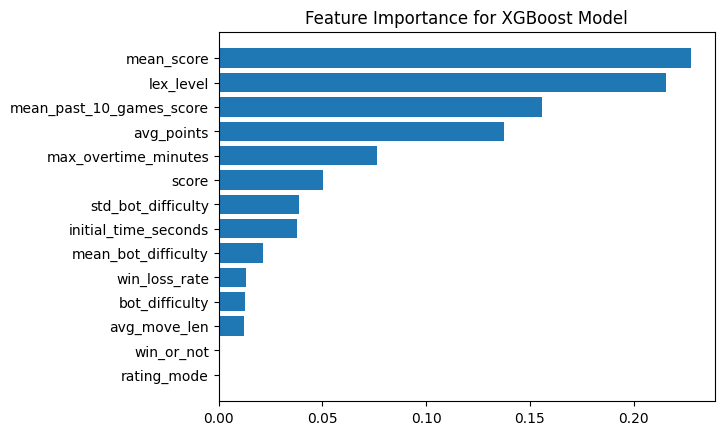

In [ ]:
def plot_feature_importance(model, feature_names, title):
    # Get feature importance data
    importance = model.feature_importances_
    # Summarize feature importance with column names
    for i,v in enumerate(importance):
        print(f'Feature: {feature_names[i]}, Score: {v:.5f}')
    # Create a sorted list of feature importances
    sorted_idx = model.feature_importances_.argsort()
    # Plot feature importance
    plt.barh(feature_names[sorted_idx], importance[sorted_idx])
    plt.title(title)
    plt.show()

# Assuming X_train is a DataFrame with column names
feature_names = input_data.drop(columns=['rating']).columns

# Plot feature importance for each model
plot_feature_importance(xgb_model, feature_names, 'Feature Importance for XGBoost Model')
#plot_feature_importance(xgb_model_2, feature_names, 'Feature Importance for XGBoost Model 2')
#plot_feature_importance(xgb_model_3, feature_names, 'Feature Importance for XGBoost Model 3')
#plot_feature_importance(xgb_model_4, feature_names, 'Feature Importance for XGBoost Model 4')


In [ ]:
test_data_real = test_data_real.drop(columns= ['rating'])
test_data_real

,score,initial_time_seconds,rating_mode,max_overtime_minutes,win_or_not,mean_score,avg_points,avg_move_len,bot_difficulty,mean_bot_difficulty,std_bot_difficulty,win_loss_rate,mean_past_10_games_score,lex_level
0,488,3600,0,1,1,391.992857,34.857143,4.357143,1,1.307143,0.462966,0.666667,417.428571,4
2,379,1260,0,1,1,375.349398,29.153846,3.846154,2,2.000000,0.000000,0.611650,381.857143,4
4,462,1200,0,1,1,405.386617,33.000000,4.214286,2,2.000000,0.000000,0.591837,407.571429,3
6,359,900,0,1,1,363.938462,23.933333,4.066667,2,2.000000,0.000000,0.527778,370.285714,4
8,456,1200,0,1,1,432.238636,41.454545,4.454545,3,3.000000,0.000000,0.460000,354.142857,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44717,494,1200,0,3,0,429.746835,49.400000,5.000000,2,2.075949,0.529082,0.539062,435.000000,4
44719,232,1200,0,1,0,293.695779,11.047619,3.285714,1,1.407569,0.523334,0.508503,300.714286,4
44720,367,3600,0,1,1,356.379310,26.214286,3.642857,1,1.000000,0.000000,0.466667,369.714286,3
44723,357,3600,0,1,1,406.250000,29.750000,4.750000,3,3.000000,0.000000,1.000000,406.250000,4


In [ ]:
ensemble_pred = ensemble_model.predict(test_data_real)

submission = pd.DataFrame()
submission['game_id'] = test[test['rating'].isnull()]['game_id']
submission['rating'] = ensemble_pred

submission.to_csv("/Users/chenshaokai/Downloads/xgboost_submission4.csv",index=False)